In [1]:
from datasets import Dataset, DatasetDict
from datetime import datetime
import os

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
import spacy
import datasets
import torchtext
import tqdm
import evaluate

In [4]:
seed = 1234

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

### Dataset

In [5]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    return s.strip()

In [6]:
def readData(lang1, lang2):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('../data/tatoeba/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    # if reverse:
    #     pairs = [list(reversed(p)) for p in pairs]
    #     input_lang = Lang(lang2)
    #     output_lang = Lang(lang1)
    # else:
    #     input_lang = Lang(lang1)
    #     output_lang = Lang(lang2)

    data = [{lang1: pair[0], lang2: pair[1]}for pair in pairs]

    return data

In [7]:
data = readData('en', 'fr')

Reading lines...


In [8]:
data[:10]

[{'en': 'go', 'fr': 'va !'},
 {'en': 'run !', 'fr': 'cours !'},
 {'en': 'run !', 'fr': 'courez !'},
 {'en': 'wow !', 'fr': 'ca alors !'},
 {'en': 'fire !', 'fr': 'au feu !'},
 {'en': 'help !', 'fr': 'a l aide !'},
 {'en': 'jump', 'fr': 'saute'},
 {'en': 'stop !', 'fr': 'ca suffit !'},
 {'en': 'stop !', 'fr': 'stop !'},
 {'en': 'stop !', 'fr': 'arrete toi !'}]

In [9]:
random.seed(1234)
# print("Before shuffle:", data[:10])
random.shuffle(data)
# print("After shuffle:", data[:10])
data[:10]

[{'en': 'it s perfect', 'fr': 'c est parfait'},
 {'en': 'i was sitting next to a man who clearly had a lot on his mind',
  'fr': 'j etais assise a cote d un homme qui avait a l evidence de nombreuses choses en tete'},
 {'en': 'we have a gig at the club tomorrow night',
  'fr': 'nous faisons un b uf au club demain soir'},
 {'en': 'i m not going to hurt you', 'fr': 'je ne vais pas te faire de mal'},
 {'en': 'apart from a filing tray full of papers on the desk everything else in the room was on the floor',
  'fr': 'en dehors d une classeur plein de papiers sur le bureau tout le reste dans la piece etait par terre'},
 {'en': 'i d like to visit your country someday',
  'fr': 'j aimerais visiter ton pays un de ces jours'},
 {'en': 'how thoughtful of you to have chilled some wine for us',
  'fr': 'comme c est attentionne de votre part d avoir mis au frais du vin pour nous'},
 {'en': 'you should cut up your meat before you eat it',
  'fr': 'tu devrais couper ta viande en morceaux avant de la m

In [10]:
# splittng data
n = len(data)
n_train = int(0.8*n)
n_val = int(0.9*n)

train_data = data[:n_train]
val_data = data[n_train:n_val]
test_data = data[n_val:]

# convert to Huggingface dataset
train_dataset = Dataset.from_list(train_data)
val_dataset = Dataset.from_list(val_data)
test_dataset = Dataset.from_list(test_data)

# Create the DatasetDict
dataset_dict = DatasetDict({
    "train": train_dataset,
    "validation": val_dataset,
    "test": test_dataset
})

In [11]:
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['en', 'fr'],
        num_rows: 108673
    })
    validation: Dataset({
        features: ['en', 'fr'],
        num_rows: 13584
    })
    test: Dataset({
        features: ['en', 'fr'],
        num_rows: 13585
    })
})

In [12]:
n

135842

In [13]:
train_dataset[0]

{'en': 'it s perfect', 'fr': 'c est parfait'}

In [14]:
en_nlp = spacy.load("en_core_web_sm")
fr_nlp = spacy.load("fr_core_news_sm")

In [15]:
string = "What a lovely day it is today!"

[token.text for token in en_nlp.tokenizer(string)]

['What', 'a', 'lovely', 'day', 'it', 'is', 'today', '!']

In [16]:
def tokenize_example(example, en_nlp, fr_nlp, max_length, lower, sos_token, eos_token):
    en_tokens = [token.text for token in en_nlp.tokenizer(example["en"])][:max_length]
    fr_tokens = [token.text for token in fr_nlp.tokenizer(example["fr"])][:max_length]
    if lower:
        en_tokens = [token.lower() for token in en_tokens]
        fr_tokens = [token.lower() for token in fr_tokens]
    en_tokens = [sos_token] + en_tokens + [eos_token]
    fr_tokens = [sos_token] + fr_tokens + [eos_token]
    return {"en_tokens": en_tokens, "fr_tokens": fr_tokens}

In [17]:
max_length = 1_000
lower = True
sos_token = "<sos>"
eos_token = "<eos>"

fn_kwargs = {
    "en_nlp": en_nlp,
    "fr_nlp": fr_nlp,
    "max_length": max_length,
    "lower": lower,
    "sos_token": sos_token,
    "eos_token": eos_token,
}

train_dataset = train_dataset.map(tokenize_example, fn_kwargs=fn_kwargs)
val_dataset = val_dataset.map(tokenize_example, fn_kwargs=fn_kwargs)
test_dataset = test_dataset.map(tokenize_example, fn_kwargs=fn_kwargs)

Map:   0%|          | 0/108673 [00:00<?, ? examples/s]

Map:   0%|          | 0/13584 [00:00<?, ? examples/s]

Map:   0%|          | 0/13585 [00:00<?, ? examples/s]

In [18]:
train_dataset[0]

{'en': 'it s perfect',
 'fr': 'c est parfait',
 'en_tokens': ['<sos>', 'it', 's', 'perfect', '<eos>'],
 'fr_tokens': ['<sos>', 'c', 'est', 'parfait', '<eos>']}

In [19]:
from torchtext.vocab import build_vocab_from_iterator
min_freq = 2
unk_token = "<unk>"
pad_token = "<pad>"

special_tokens = [
    unk_token,
    pad_token,
    sos_token,
    eos_token,
]

en_vocab = build_vocab_from_iterator(
    train_dataset["en_tokens"],
    min_freq=min_freq,
    specials=special_tokens,
)

fr_vocab = build_vocab_from_iterator(
    train_dataset["fr_tokens"],
    min_freq=min_freq,
    specials=special_tokens,
)

/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


In [20]:
en_vocab.get_itos()[:10]

['<unk>', '<pad>', '<sos>', '<eos>', 'i', 'you', 'to', 'the', '?', 'a']

In [21]:
fr_vocab.get_itos()[:10]

['<unk>', '<pad>', '<sos>', '<eos>', 'je', 'a', 'de', '?', 'pas', 'vous']

In [22]:
en_vocab['the']

7

In [23]:
len(en_vocab), len(fr_vocab)

(8135, 12253)

In [24]:
assert en_vocab[unk_token] == fr_vocab[unk_token]
assert en_vocab[pad_token] == fr_vocab[pad_token]

unk_index = en_vocab[unk_token]
pad_index = en_vocab[pad_token]

In [25]:
en_vocab['The']

RuntimeError: Token The not found and default index is not set

In [28]:
en_vocab.set_default_index(unk_index)
fr_vocab.set_default_index(unk_index)

In [29]:
en_vocab['The']

0

In [30]:
en_vocab.get_itos()[0]

'<unk>'

In [31]:
tokens = ["i", "love", "watching", "crime", "shows"]
en_vocab.lookup_indices(tokens)

[4, 136, 539, 1060, 3174]

In [32]:
en_vocab.lookup_tokens(en_vocab.lookup_indices(tokens))

['i', 'love', 'watching', 'crime', 'shows']

In [33]:
def numericalize_example(example, en_vocab, fr_vocab):
    en_ids = en_vocab.lookup_indices(example["en_tokens"])
    fr_ids = fr_vocab.lookup_indices(example["fr_tokens"])
    return {"en_ids": en_ids, "fr_ids": fr_ids}

In [34]:
fn_kwargs = {"en_vocab": en_vocab, "fr_vocab": fr_vocab}

train_dataset = train_dataset.map(numericalize_example, fn_kwargs=fn_kwargs)
val_dataset = val_dataset.map(numericalize_example, fn_kwargs=fn_kwargs)
test_dataset = test_dataset.map(numericalize_example, fn_kwargs=fn_kwargs)

Map:   0%|          | 0/108673 [00:00<?, ? examples/s]

Map:   0%|          | 0/13584 [00:00<?, ? examples/s]

Map:   0%|          | 0/13585 [00:00<?, ? examples/s]

In [35]:
train_dataset[0]

{'en': 'it s perfect',
 'fr': 'c est parfait',
 'en_tokens': ['<sos>', 'it', 's', 'perfect', '<eos>'],
 'fr_tokens': ['<sos>', 'c', 'est', 'parfait', '<eos>'],
 'en_ids': [2, 12, 15, 749, 3],
 'fr_ids': [2, 33, 10, 1072, 3]}

In [36]:
data_type = "torch"
format_columns = ["en_ids", "fr_ids"]

train_dataset = train_dataset.with_format(
    type=data_type, columns=format_columns, output_all_columns=True
)

val_dataset = val_dataset.with_format(
    type=data_type,
    columns=format_columns,
    output_all_columns=True,
)

test_dataset = test_dataset.with_format(
    type=data_type,
    columns=format_columns,
    output_all_columns=True,
)

In [37]:
train_dataset[0]

{'en_ids': tensor([  2,  12,  15, 749,   3]),
 'fr_ids': tensor([   2,   33,   10, 1072,    3]),
 'en': 'it s perfect',
 'fr': 'c est parfait',
 'en_tokens': ['<sos>', 'it', 's', 'perfect', '<eos>'],
 'fr_tokens': ['<sos>', 'c', 'est', 'parfait', '<eos>']}

In [38]:
train_dataset[0]

{'en_ids': tensor([  2,  12,  15, 749,   3]),
 'fr_ids': tensor([   2,   33,   10, 1072,    3]),
 'en': 'it s perfect',
 'fr': 'c est parfait',
 'en_tokens': ['<sos>', 'it', 's', 'perfect', '<eos>'],
 'fr_tokens': ['<sos>', 'c', 'est', 'parfait', '<eos>']}

### Dataloaders

In [39]:
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_en_ids = [example["en_ids"] for example in batch]
        batch_fr_ids = [example["fr_ids"] for example in batch]
        en_lens = [example["en_ids"].shape[0] for example in batch]
        fr_lens = [example["fr_ids"].shape[0] for example in batch]
        batch_en_ids = nn.utils.rnn.pad_sequence(batch_en_ids, padding_value=pad_index)
        batch_fr_ids = nn.utils.rnn.pad_sequence(batch_fr_ids, padding_value=pad_index)
        batch = {
            "en_ids": batch_en_ids,
            "fr_ids": batch_fr_ids,
            "en_lens": en_lens,
            "fr_lens": fr_lens
        }
        return batch

    return collate_fn

In [40]:
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader

In [41]:
batch_size = 128

train_data_loader = get_data_loader(train_dataset, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(val_dataset, batch_size, pad_index)
test_data_loader = get_data_loader(test_dataset, batch_size, pad_index)

In [42]:
len(valid_data_loader)

107

In [43]:
len(test_data_loader)

107

In [44]:
len(train_data_loader)

850

### Model

In [45]:
class Encoder(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, n_layers, dropout):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_lens):
        # src = [src length, batch size]
        embedded = self.dropout(self.embedding(src))
        # embedded = [src length, batch size, embedding dim]
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, np.array(src_lens), enforce_sorted=False, batch_first=False)
        packed_outputs, (hidden, cell) = self.rnn(packed)
        # outputs, (hidden, cell) = self.rnn(embedded)
        # outputs = [src length, batch size, hidden dim * n directions]
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]
        # outputs are always from the top hidden layer
        return hidden, cell

In [46]:
class Decoder(nn.Module):
    def __init__(self, output_dim, embedding_dim, hidden_dim, n_layers, dropout):
        super().__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(output_dim, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=dropout)
        self.fc_out = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, cell):
        # input = [batch size]
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]
        # n directions in the decoder will both always be 1, therefore:
        # hidden = [n layers, batch size, hidden dim]
        # context = [n layers, batch size, hidden dim]
        input = input.unsqueeze(0)
        # input = [1, batch size]
        embedded = self.dropout(self.embedding(input))
        # embedded = [1, batch size, embedding dim]
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        # output = [seq length, batch size, hidden dim * n directions]
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]
        # seq length and n directions will always be 1 in this decoder, therefore:
        # output = [1, batch size, hidden dim]
        # hidden = [n layers, batch size, hidden dim]
        # cell = [n layers, batch size, hidden dim]
        prediction = self.fc_out(output.squeeze(0))
        # prediction = [batch size, output dim]
        return prediction, hidden, cell

In [47]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        assert (
            encoder.hidden_dim == decoder.hidden_dim
        ), "Hidden dimensions of encoder and decoder must be equal!"
        assert (
            encoder.n_layers == decoder.n_layers
        ), "Encoder and decoder must have equal number of layers!"

    def forward(self, src, src_lens, trg, trg_lens, teacher_forcing_ratio):
        # src = [src length, batch size]
        # trg = [trg length, batch size]
        # teacher_forcing_ratio is probability to use teacher forcing
        # e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        batch_size = trg.shape[1]
        trg_length = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        # tensor to store decoder outputs
        outputs = torch.zeros(trg_length, batch_size, trg_vocab_size).to(self.device)
        # last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src, src_lens)
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]
        # first input to the decoder is the <sos> tokens
        input = trg[0, :]
        # input = [batch size]
        for t in range(1, trg_length):
            # insert input token embedding, previous hidden and previous cell states
            # receive output tensor (predictions) and new hidden and cell states
            output, hidden, cell = self.decoder(input, hidden, cell)
            # output = [batch size, output dim]
            # hidden = [n layers, batch size, hidden dim]
            # cell = [n layers, batch size, hidden dim]
            # place predictions in a tensor holding predictions for each token
            outputs[t] = output
            # decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            # get the highest predicted token from our predictions
            top1 = output.argmax(1)
            # if teacher forcing, use actual next token as next input
            # if not, use predicted token
            input = trg[t] if teacher_force else top1
            # input = [batch size]
        return outputs

### Training

In [48]:
input_dim = len(fr_vocab)
output_dim = len(en_vocab)
encoder_embedding_dim = 256
decoder_embedding_dim = 256
hidden_dim = 512
n_layers = 2
encoder_dropout = 0.5
decoder_dropout = 0.5
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

encoder = Encoder(
    input_dim,
    encoder_embedding_dim,
    hidden_dim,
    n_layers,
    encoder_dropout,
)

decoder = Decoder(
    output_dim,
    decoder_embedding_dim,
    hidden_dim,
    n_layers,
    decoder_dropout,
)

model = Seq2Seq(encoder, decoder, device).to(device)

In [49]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)


model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(12253, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(8135, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (fc_out): Linear(in_features=512, out_features=8135, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [50]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 16,748,999 trainable parameters


In [51]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=pad_index)
# scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [52]:
def train_fn(
    model, data_loader, optimizer, criterion, clip, teacher_forcing_ratio, device
):
    model.train()
    epoch_loss = 0
    for i, batch in enumerate(data_loader):
        src = batch["fr_ids"].to(device)
        src_lens = batch["fr_lens"]
        trg = batch["en_ids"].to(device)
        trg_lens = batch["en_lens"]
        # src = [src length, batch size]
        # trg = [trg length, batch size]
        optimizer.zero_grad()
        output = model(src, src_lens, trg, trg_lens, teacher_forcing_ratio)
        # output = [trg length, batch size, trg vocab size]
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        # output = [(trg length - 1) * batch size, trg vocab size]
        trg = trg[1:].view(-1)
        # trg = [(trg length - 1) * batch size]
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        # scheduler.step()
        epoch_loss += loss.item()
    return epoch_loss / len(data_loader)

In [53]:
def evaluate_fn(model, data_loader, criterion, device):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            src = batch["fr_ids"].to(device)
            src_lens = batch["fr_lens"]
            trg = batch["en_ids"].to(device)
            trg_lens = batch["en_lens"]
            # src = [src length, batch size]
            # trg = [trg length, batch size]
            output = model(src, src_lens, trg, trg_lens, 0)  # turn off teacher forcing
            # output = [trg length, batch size, trg vocab size]
            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            # output = [(trg length - 1) * batch size, trg vocab size]
            trg = trg[1:].view(-1)
            # trg = [(trg length - 1) * batch size]
            loss = criterion(output, trg)
            epoch_loss += loss.item()
    return epoch_loss / len(data_loader)

In [51]:
n_epochs = 20
clip = 1.0
teacher_forcing_ratio = 0.5

best_valid_loss = float("inf")

date = datetime.today().strftime('%Y-%m-%d')
model_dir = f'../models/tatoeba/{date}'
# Create the directory
try:
    os.mkdir(model_dir)
    print(f"Directory '{model_dir}' created successfully.")
except FileExistsError:
    print(f"Directory '{model_dir}' already exists.")

train_lossi = []
val_lossi = []  

for epoch in tqdm.tqdm(range(n_epochs)):
    train_loss = train_fn(
        model,
        train_data_loader,
        optimizer,
        criterion,
        clip,
        teacher_forcing_ratio,
        device,
    )
    valid_loss = evaluate_fn(
        model,
        valid_data_loader,
        criterion,
        device,
    )

    train_lossi.append(train_loss)
    val_lossi.append(valid_loss)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), os.path.join(model_dir, f'mt_tatoeba_{train_loss:7.2f}_{valid_loss:7.2f}.pt'))
    print(f"\tTrain Loss: {train_loss:7.3f} | Train PPL: {np.exp(train_loss):7.3f}")
    print(f"\tValid Loss: {valid_loss:7.3f} | Valid PPL: {np.exp(valid_loss):7.3f}")

Directory '../models/tatoeba/2024-11-30' already exists.


  5%|███▍                                                                | 1/20 [02:51<54:23, 171.75s/it]

	Train Loss:   4.426 | Train PPL:  83.585
	Valid Loss:   3.987 | Valid PPL:  53.870


 10%|██████▊                                                             | 2/20 [06:13<56:53, 189.63s/it]

	Train Loss:   3.400 | Train PPL:  29.951
	Valid Loss:   3.394 | Valid PPL:  29.791


 15%|██████████▏                                                         | 3/20 [10:07<59:23, 209.65s/it]

	Train Loss:   2.859 | Train PPL:  17.445
	Valid Loss:   3.016 | Valid PPL:  20.400


 20%|█████████████▏                                                    | 4/20 [14:38<1:02:21, 233.82s/it]

	Train Loss:   2.479 | Train PPL:  11.928
	Valid Loss:   2.786 | Valid PPL:  16.216


 25%|████████████████▌                                                 | 5/20 [19:32<1:03:54, 255.60s/it]

	Train Loss:   2.216 | Train PPL:   9.171
	Valid Loss:   2.613 | Valid PPL:  13.636


 30%|███████████████████▊                                              | 6/20 [24:49<1:04:30, 276.49s/it]

	Train Loss:   2.013 | Train PPL:   7.488
	Valid Loss:   2.494 | Valid PPL:  12.105


 35%|███████████████████████                                           | 7/20 [31:21<1:08:05, 314.27s/it]

	Train Loss:   1.848 | Train PPL:   6.344
	Valid Loss:   2.417 | Valid PPL:  11.215


 40%|██████████████████████████▍                                       | 8/20 [38:02<1:08:21, 341.82s/it]

	Train Loss:   1.729 | Train PPL:   5.633
	Valid Loss:   2.365 | Valid PPL:  10.647


 45%|█████████████████████████████▋                                    | 9/20 [45:03<1:07:12, 366.58s/it]

	Train Loss:   1.630 | Train PPL:   5.104
	Valid Loss:   2.320 | Valid PPL:  10.174


 50%|████████████████████████████████▌                                | 10/20 [52:14<1:04:23, 386.39s/it]

	Train Loss:   1.537 | Train PPL:   4.650
	Valid Loss:   2.282 | Valid PPL:   9.799


 55%|███████████████████████████████████▊                             | 11/20 [59:42<1:00:47, 405.33s/it]

	Train Loss:   1.469 | Train PPL:   4.346
	Valid Loss:   2.273 | Valid PPL:   9.711


 60%|███████████████████████████████████████                          | 12/20 [1:07:26<56:24, 423.12s/it]

	Train Loss:   1.412 | Train PPL:   4.102
	Valid Loss:   2.233 | Valid PPL:   9.324


 65%|██████████████████████████████████████████▎                      | 13/20 [1:16:03<52:42, 451.72s/it]

	Train Loss:   1.354 | Train PPL:   3.873
	Valid Loss:   2.233 | Valid PPL:   9.325


 70%|█████████████████████████████████████████████▌                   | 14/20 [1:26:21<50:12, 502.00s/it]

	Train Loss:   1.311 | Train PPL:   3.710
	Valid Loss:   2.228 | Valid PPL:   9.277


 75%|████████████████████████████████████████████████▊                | 15/20 [1:36:55<45:08, 541.72s/it]

	Train Loss:   1.267 | Train PPL:   3.551
	Valid Loss:   2.212 | Valid PPL:   9.137


 80%|████████████████████████████████████████████████████             | 16/20 [1:47:47<38:19, 574.76s/it]

	Train Loss:   1.235 | Train PPL:   3.440
	Valid Loss:   2.207 | Valid PPL:   9.090


 85%|███████████████████████████████████████████████████████▎         | 17/20 [1:59:10<30:22, 607.39s/it]

	Train Loss:   1.203 | Train PPL:   3.329
	Valid Loss:   2.208 | Valid PPL:   9.095


 90%|██████████████████████████████████████████████████████████▌      | 18/20 [2:10:39<21:04, 632.02s/it]

	Train Loss:   1.180 | Train PPL:   3.255
	Valid Loss:   2.203 | Valid PPL:   9.049


 95%|█████████████████████████████████████████████████████████████▊   | 19/20 [2:23:06<11:06, 666.54s/it]

	Train Loss:   1.153 | Train PPL:   3.168
	Valid Loss:   2.219 | Valid PPL:   9.194


100%|█████████████████████████████████████████████████████████████████| 20/20 [2:35:55<00:00, 467.77s/it]

	Train Loss:   1.132 | Train PPL:   3.102
	Valid Loss:   2.216 | Valid PPL:   9.166


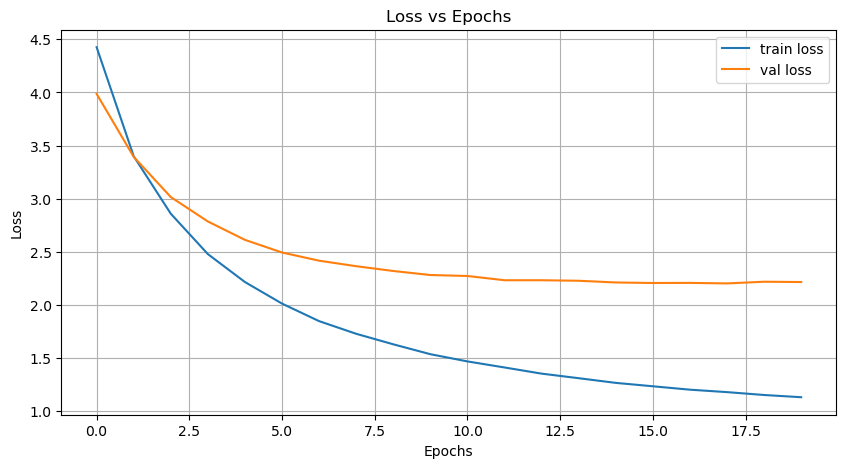

In [157]:
import matplotlib.pyplot as plt
train_loss_end = [4.426, 3.400, 2.859, 2.479, 2.216, 2.013, 1.848, 1.729, 1.630, 1.537, 1.469, 1.412, 1.354, 1.311, 1.267, 1.235, 1.203, 1.180, 1.153, 1.132]
train_ppl_end = [83.585, 29.951, 17.445, 11.928, 9.171, 7.488, 6.344, 5.633, 5.104, 4.650, 4.346, 4.102, 3.873, 3.710, 3.551, 3.440, 3.329, 3.255, 3.168, 3.102]
val_loss_end = [3.987, 3.394, 3.016, 2.786, 2.613, 2.494, 2.417, 2.365, 2.320, 2.282, 2.273, 2.233, 2.233, 2.228, 2.212, 2.207, 2.208, 2.203, 2.219, 2.216]
val_ppl_end = [53.870, 29.791, 20.400, 16.216, 13.636, 12.105, 11.215, 10.647, 10.174, 9.799, 9.711, 9.324, 9.325, 9.277, 9.137, 9.090, 9.095, 9.049, 9.194, 9.166]

# train_loss_end += train_lossi
# val_loss_end += val_lossi
fig = plt.figure(figsize=(10,5))
plt.plot(train_loss_end, label='train loss')
plt.plot(val_loss_end, label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.grid()
plt.show()

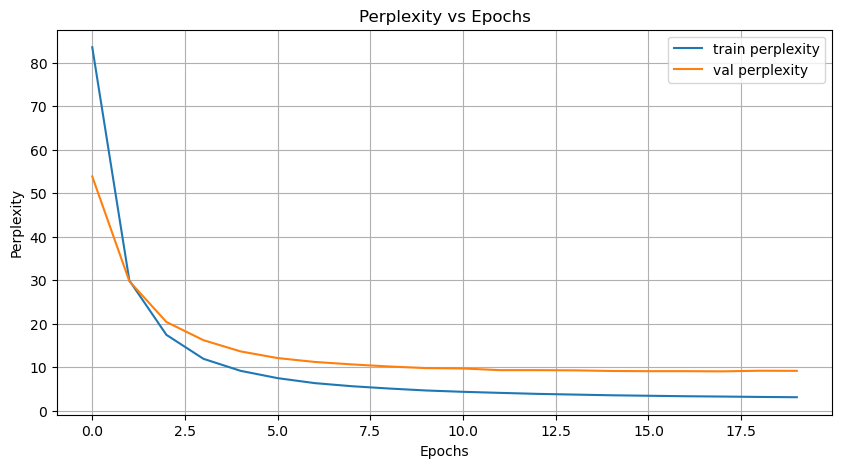

In [158]:
fig = plt.figure(figsize=(10,5))
plt.plot(train_ppl_end, label='train perplexity')
plt.plot(val_ppl_end, label='val perplexity')
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.title('Perplexity vs Epochs')
plt.legend()
plt.grid()
plt.show()

### Evaluating on test set

In [118]:
model.load_state_dict(torch.load(os.path.join(f'../models/tatoeba/2024-11-30/', f'mt_tatoeba.pt')))

test_loss = evaluate_fn(model, test_data_loader, criterion, device)

print(f"| Test Loss: {test_loss:.3f} | Test PPL: {np.exp(test_loss):7.3f} |")

| Test Loss: 2.126 | Test PPL:   8.378 |


### BLEU score

In [119]:
def translate_sentence(
    sentence,
    model,
    en_nlp,
    fr_nlp,
    en_vocab,
    fr_vocab,
    lower,
    sos_token,
    eos_token,
    device,
    max_output_length=25,
):
    model.eval()
    with torch.no_grad():
        if isinstance(sentence, str):
            tokens = [token.text for token in fr_nlp.tokenizer(sentence)]
        else:
            tokens = [token for token in sentence]
        if lower:
            tokens = [token.lower() for token in tokens]
        tokens = [sos_token] + tokens + [eos_token]
        ids = fr_vocab.lookup_indices(tokens)
        tensor = torch.LongTensor(ids).unsqueeze(-1).to(device)
        src_len = [tensor.shape[0]]
        hidden, cell = model.encoder(tensor, src_len)
        inputs = en_vocab.lookup_indices([sos_token])
        for _ in range(max_output_length):
            inputs_tensor = torch.LongTensor([inputs[-1]]).to(device)
            output, hidden, cell = model.decoder(inputs_tensor, hidden, cell)
            predicted_token = output.argmax(-1).item()
            inputs.append(predicted_token)
            if predicted_token == en_vocab[eos_token]:
                break
        tokens = en_vocab.lookup_tokens(inputs)
    return tokens

In [120]:
sentence = test_data[0]["fr"]
expected_translation = test_data[0]["en"]

sentence, expected_translation

('laissez les mains sur le volant', 'keep your hands on the wheel')

In [121]:
translation = translate_sentence(
    sentence,
    model,
    en_nlp,
    fr_nlp,
    en_vocab,
    fr_vocab,
    lower,
    sos_token,
    eos_token,
    device,
)

In [122]:
translation

['<sos>', 'keep', 'your', 'hands', 'on', 'the', 'wheel', '<eos>']

In [123]:
sentence = "Bonjour."

In [124]:
translation = translate_sentence(
    sentence,
    model,
    en_nlp,
    fr_nlp,
    en_vocab,
    fr_vocab,
    lower,
    sos_token,
    eos_token,
    device,
)

In [125]:
translation

['<sos>', 'good', 'lesson', '<eos>']

In [126]:
translations = [
    translate_sentence(
        example["fr"],
        model,
        en_nlp,
        fr_nlp,
        en_vocab,
        fr_vocab,
        lower,
        sos_token,
        eos_token,
        device,
    )
    for example in tqdm.tqdm(test_dataset)
]

100%|████████████████████████████████████████████████████████████████| 13585/13585 [02:56<00:00, 77.07it/s]


In [127]:
bleu = evaluate.load("bleu")

In [128]:
predictions = [" ".join(translation[1:-1]) for translation in translations]

references = [[example["en"]] for example in test_dataset]

In [129]:
for i in range(100):
    print(f'{predictions[i]}, {references[i]}, {test_dataset[i]["fr"]}')

keep your hands on the wheel, ['keep your hands on the wheel'], laissez les mains sur le volant
his teacher must be filled with him, ['his teacher should be strict with him'], son professeur devrait etre strict avec lui
what was you up ?, ['what s kept you ?'], qu est ce qui t a retenu ?
i don t know who did it, ['i don t know who did it'], je ne sais pas qui l a fait
i make you nervous don t i ?, ['i make you nervous don t i ?'], je te rends nerveux n est ce pas ?
i don t have much clue, ['i don t have the slightest clue'], je n en ai pas la moindre idee
i don t yet know what i m doing, ['i don t know what i m doing yet'], je ne sais pas encore ce que je fais
will you dance with me ?, ['do you want to dance with me ?'], veux tu danser avec moi ?
it s not the human size, ['size does not matter'], ce n est pas la taille qui compte
i ve heard all about you, ['i ve heard all about you'], j ai tout entendu a ton sujet
the early that hotel is too difficult for me, ['the food at that restaur

In [100]:
test_dataset[0]

{'en_ids': tensor([   2,  192,   31,  483,   39,    7, 2844,    3]),
 'fr_ids': tensor([   2,  357,   28,  538,   66,   15, 2639,    3]),
 'en': 'keep your hands on the wheel',
 'fr': 'laissez les mains sur le volant',
 'en_tokens': ['<sos>',
  'keep',
  'your',
  'hands',
  'on',
  'the',
  'wheel',
  '<eos>'],
 'fr_tokens': ['<sos>',
  'laissez',
  'les',
  'mains',
  'sur',
  'le',
  'volant',
  '<eos>']}

In [101]:
def get_tokenizer_fn(nlp, lower):
    def tokenizer_fn(s):
        tokens = [token.text for token in nlp.tokenizer(s)]
        if lower:
            tokens = [token.lower() for token in tokens]
        return tokens

    return tokenizer_fn

In [102]:
tokenizer_fn = get_tokenizer_fn(en_nlp, lower)

In [103]:
tokenizer_fn(predictions[0]), tokenizer_fn(references[0][0])

(['keep', 'your', 'hands', 'on', 'the', 'wheel'],
 ['keep', 'your', 'hands', 'on', 'the', 'wheel'])

In [104]:
results = bleu.compute(
    predictions=predictions, references=references, tokenizer=tokenizer_fn
)

In [105]:
results

{'bleu': 0.4440880208080938,
 'precisions': [0.6884195643529359,
  0.49601673879423497,
  0.3825952463621729,
  0.30454399614983557],
 'brevity_penalty': 0.994338536351338,
 'length_ratio': 0.9943545021198076,
 'translation_length': 90532,
 'reference_length': 91046}

### Cross testing with Wiki test set

In [133]:
model.load_state_dict(torch.load(os.path.join(f'../models/tatoeba/2024-11-30/', f'mt_tatoeba.pt')))

test_loss = evaluate_fn(model, test_data_loader, criterion, device)

print(f"| Test Loss: {test_loss:.3f} | Test PPL: {np.exp(test_loss):7.3f} |")

| Test Loss: 2.126 | Test PPL:   8.378 |


In [134]:
from lxml import etree

def tmx_to_tabbed_txt(tmx_file, output_file):
    """Extracts English and Hawaiian translations from a TMX file and saves them as tab-separated pairs."""
    
    # Define the XML namespace for `xml:lang`
    namespaces = {'xml': 'http://www.w3.org/XML/1998/namespace'}
    
    # Parse the TMX file
    xml_tree = etree.parse(tmx_file)
    trans_units = xml_tree.findall(".//tu")

    pairs = []
    
    # Open the output file for writing
    with open(output_file, "w", encoding="utf-8") as out_file:
        # Iterate over each translation unit
        for trans_unit in trans_units:
            pair = []
            source_text = trans_unit.find(".//tuv[@xml:lang='en']/seg", namespaces)
            target_text = trans_unit.find(".//tuv[@xml:lang='fr']/seg", namespaces)

            # Write the tab-separated pair if both texts are available
            if source_text is not None and target_text is not None and source_text.text and target_text.text:
                out_file.write(f"{source_text.text}\t{target_text.text}\n")
                pair.append(source_text.text)
                pair.append(target_text.text)
                pairs.append(pair)

    return pairs

if __name__ == "__main__":
    tmx_file = "../data/wiki/en-fr.tmx"
    output_file = "../data/wiki/en-fr.txt"
    wiki_pairs = tmx_to_tabbed_txt(tmx_file, output_file)

In [135]:
wiki_pairs = [[normalizeString(sentence) for sentence in pair] for pair in wiki_pairs]
len(wiki_pairs)

1365840

In [136]:
wiki_cleaned_pairs = [pair for pair in wiki_pairs if (len(pair[0]) > 0 and len(pair[0]) <= 41) and (len(pair[0]) > 0 and len(pair[0]) <= 41)]
len(wiki_cleaned_pairs)

137932

In [137]:
wiki_data = [{'en': pair[0], 'fr': pair[1]} for pair in wiki_cleaned_pairs]
wiki_data[:10]

[{'en': 'third stream', 'fr': 'le third stream'},
 {'en': 'gil evans influence', 'fr': 'l influence de gil evans'},
 {'en': 'the horn in the spotlight', 'fr': 'le cor sous les projecteurs'},
 {'en': 'contemporary horn in jazz', 'fr': 'le cor dans le jazz contemporain'},
 {'en': 'horn in jazz', 'fr': 'utilisateur djiboun le cor dans le jazz'},
 {'en': 'murder of jewish civil rights activists',
  'fr': 'meurtre de militants juifs des droits civiques'},
 {'en': 'questioning the golden age', 'fr': 'interrogations sur l age d or'},
 {'en': 'the problem was the condescending tone',
  'fr': 'le probleme etait le ton condescendant'},
 {'en': 'press of mississippi p lindemann albert s',
  'fr': 'black jewish relations on trial leo frank and jim conley in the new south univ'},
 {'en': 'edwards brent hayes', 'fr': 'note on the text'}]

In [138]:
random.seed(seed)
random.shuffle(wiki_data)

In [139]:
# splittng data
wiki_n = len(wiki_data)
wiki_n_train = int(0.8*wiki_n)
wiki_n_val = int(0.9*wiki_n)

wiki_train_data = wiki_data[:wiki_n_train]
wiki_val_data = wiki_data[wiki_n_train:wiki_n_val]
wiki_test_data = wiki_data[wiki_n_val:]

# convert to Huggingface dataset
wiki_train_dataset = Dataset.from_list(wiki_train_data)
wiki_val_dataset = Dataset.from_list(wiki_val_data)
wiki_test_dataset = Dataset.from_list(wiki_test_data)

# Create the DatasetDict
wiki_dataset_dict = DatasetDict({
    "train": wiki_train_dataset,
    "validation": wiki_val_dataset,
    "test": wiki_test_dataset
})

In [140]:
wiki_dataset_dict

DatasetDict({
    train: Dataset({
        features: ['en', 'fr'],
        num_rows: 110345
    })
    validation: Dataset({
        features: ['en', 'fr'],
        num_rows: 13793
    })
    test: Dataset({
        features: ['en', 'fr'],
        num_rows: 13794
    })
})

In [141]:
en_nlp = spacy.load("en_core_web_sm")
fr_nlp = spacy.load("fr_core_news_sm")

In [142]:
string = "What a lovely day it is today!"

[token.text for token in en_nlp.tokenizer(string)]

['What', 'a', 'lovely', 'day', 'it', 'is', 'today', '!']

In [143]:
def tokenize_example(example, en_nlp, fr_nlp, max_length, lower, sos_token, eos_token):
    en_tokens = [token.text for token in en_nlp.tokenizer(example["en"])][:max_length]
    fr_tokens = [token.text for token in fr_nlp.tokenizer(example["fr"])][:max_length]
    if lower:
        en_tokens = [token.lower() for token in en_tokens]
        fr_tokens = [token.lower() for token in fr_tokens]
    en_tokens = [sos_token] + en_tokens + [eos_token]
    fr_tokens = [sos_token] + fr_tokens + [eos_token]
    return {"en_tokens": en_tokens, "fr_tokens": fr_tokens}

In [144]:
max_length = 40
lower = True
sos_token = "<sos>"
eos_token = "<eos>"

fn_kwargs = {
    "en_nlp": en_nlp,
    "fr_nlp": fr_nlp,
    "max_length": max_length,
    "lower": lower,
    "sos_token": sos_token,
    "eos_token": eos_token,
}

wiki_train_dataset = wiki_train_dataset.map(tokenize_example, fn_kwargs=fn_kwargs)
wiki_val_dataset = wiki_val_dataset.map(tokenize_example, fn_kwargs=fn_kwargs)
wiki_test_dataset = wiki_test_dataset.map(tokenize_example, fn_kwargs=fn_kwargs)

Map:   0%|          | 0/110345 [00:00<?, ? examples/s]

Map:   0%|          | 0/13793 [00:00<?, ? examples/s]

Map:   0%|          | 0/13794 [00:00<?, ? examples/s]

In [145]:
from torchtext.vocab import build_vocab_from_iterator
wiki_min_freq = 2
wiki_unk_token = "<unk>"
wiki_pad_token = "<pad>"

special_tokens = [
    wiki_unk_token,
    wiki_pad_token,
    sos_token,
    eos_token,
]

wiki_en_vocab = build_vocab_from_iterator(
    wiki_train_dataset["en_tokens"],
    min_freq=wiki_min_freq,
    specials=special_tokens,
)

wiki_fr_vocab = build_vocab_from_iterator(
    wiki_train_dataset["fr_tokens"],
    min_freq=wiki_min_freq,
    specials=special_tokens,
)

In [146]:
assert wiki_en_vocab[wiki_unk_token] == wiki_fr_vocab[wiki_unk_token]
assert wiki_en_vocab[wiki_pad_token] == wiki_fr_vocab[wiki_pad_token]

wiki_unk_index = wiki_en_vocab[wiki_unk_token]
wiki_pad_index = wiki_en_vocab[wiki_pad_token]

In [147]:
wiki_en_vocab.set_default_index(wiki_unk_index)
wiki_fr_vocab.set_default_index(wiki_unk_index)

In [148]:
def numericalize_example(example, en_vocab, fr_vocab):
    en_ids = en_vocab.lookup_indices(example["en_tokens"])
    fr_ids = fr_vocab.lookup_indices(example["fr_tokens"])
    return {"en_ids": en_ids, "fr_ids": fr_ids}

In [149]:
fn_kwargs = {"en_vocab": wiki_en_vocab, "fr_vocab": wiki_fr_vocab}

wiki_train_dataset = wiki_train_dataset.map(numericalize_example, fn_kwargs=fn_kwargs)
wiki_val_dataset = wiki_val_dataset.map(numericalize_example, fn_kwargs=fn_kwargs)
wiki_test_dataset = wiki_test_dataset.map(numericalize_example, fn_kwargs=fn_kwargs)

Map:   0%|          | 0/110345 [00:00<?, ? examples/s]

Map:   0%|          | 0/13793 [00:00<?, ? examples/s]

Map:   0%|          | 0/13794 [00:00<?, ? examples/s]

In [ ]:
# data_type = "torch"
# format_columns = ["en_ids", "fr_ids"]

# wiki_train_dataset = wiki_train_dataset.with_format(
#     type=data_type, columns=format_columns, output_all_columns=True
# )

# wiki_val_dataset = wiki_val_dataset.with_format(
#     type=data_type,
#     columns=format_columns,
#     output_all_columns=True,
# )

# wiki_test_dataset = wiki_test_dataset.with_format(
#     type=data_type,
#     columns=format_columns,
#     output_all_columns=True,
# )

In [ ]:
# wiki_batch_size = 128

# wiki_train_data_loader = get_data_loader(wiki_train_dataset, wiki_batch_size, wiki_pad_index, shuffle=True)
# wiki_valid_data_loader = get_data_loader(wiki_val_dataset, wiki_batch_size, wiki_pad_index)
# wiki_test_data_loader = get_data_loader(wiki_test_dataset, wiki_batch_size, wiki_pad_index)

### BLEU score on wiki test set

In [150]:
translations = [
    translate_sentence(
        example["fr"],
        model,
        en_nlp,
        fr_nlp,
        en_vocab,
        fr_vocab,
        lower,
        sos_token,
        eos_token,
        device,
    )
    for example in tqdm.tqdm(wiki_test_dataset)
]

100%|████████████████████████████████████████████████████████████████| 13794/13794 [02:22<00:00, 96.79it/s]


In [151]:
bleu = evaluate.load("bleu")

In [152]:
predictions = [" ".join(translation[1:-1]) for translation in translations]

references = [[example["en"]] for example in wiki_test_dataset]

In [153]:
for i in range(100):
    print(f'{predictions[i+100]}, {references[i+100]}, {wiki_test_dataset[i+100]["fr"]}')

monkeys cheered, ['staff'], equipes
<unk> <unk> died, ['robert brydges b died young'], robert brydges b mort jeune
let <unk> <unk> <unk> <unk> <unk>, ['official website lgbtq video game archive'], site officiel lgbtq video game archive
divide <unk>, ['extraterritorial jurisdiction'], competence extraterritoriale
his english is his ignorance, ['life and career'], sa vie et sa carriere
as far as he thought, ['as writer'], en tant qu auteur
he s a <unk> officer, ['he is a police superintendent'], c est un commissaire de police
<unk> <unk> <unk> the ceiling, ['official website'], official website portail du jeu video
this experiment has <unk>, ['behrens fisher problem'], probleme de behrens fisher
<unk> <unk> <unk> unharmed in the <unk>, ['st rhode island volunteers at camp alger'], st rhode island volunteers au camp alger
twenty thirty run, ['graduate school'], deuxieme cycle
forty lives, ['western countries'], pays occidentaux
let s <unk>, ['madrasa asfouria'], medersa asfouria
the band 

In [110]:
wiki_test_dataset[0]

{'en': 'national songs',
 'fr': 'musiques nationales',
 'en_tokens': ['<sos>', 'national', 'songs', '<eos>'],
 'fr_tokens': ['<sos>', 'musiques', 'nationales', '<eos>'],
 'en_ids': [2, 111, 593, 3],
 'fr_ids': [2, 5012, 2367, 3]}

In [111]:
def get_tokenizer_fn(nlp, lower):
    def tokenizer_fn(s):
        tokens = [token.text for token in nlp.tokenizer(s)]
        if lower:
            tokens = [token.lower() for token in tokens]
        return tokens

    return tokenizer_fn

In [112]:
tokenizer_fn = get_tokenizer_fn(en_nlp, lower)

In [113]:
tokenizer_fn(predictions[0]), tokenizer_fn(references[0][0])

(['let', 's', '<', 'unk', '>'], ['national', 'songs'])

In [114]:
results = bleu.compute(
    predictions=predictions, references=references, tokenizer=tokenizer_fn
)

In [115]:
results

{'bleu': 0.011042315644887286,
 'precisions': [0.08006872237235356,
  0.01810943242139649,
  0.005576583097020681,
  0.0018386739090768733],
 'brevity_penalty': 1.0,
 'length_ratio': 1.9755343032402906,
 'translation_length': 111754,
 'reference_length': 56569}